In [1]:
# [RDKitでBRICSを用いた仮想ライブラリーの構築 | 化学の新しいカタチ](https://future-chem.com/rdkit-brics/)
# https://future-chem.com/rdkit-brics/

In [3]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, Recap
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import BRICS
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

In [4]:
# platinum dataset is found below
# [Servers & Datasets](https://comp3d.univie.ac.at/servers-datasets/#c523270)
suppl = Chem.SDMolSupplier('./sdf/platinum_dataset_2017_01.sdf')
mols = [x for x in suppl if x is not None]
len(mols)

4548

In [5]:
# fragmentation by BRICS
frag = BRICS.BRICSDecompose(mols[0])
print(len(frag))
print(frag)

5
{'[16*]c1ccccc1', '[1*]C(=O)C(C[8*])CC(=O)N[O-]', '[1*]C(=O)C([4*])C(C)CC', '[4*]C(CC(C)C)C(=O)[O-]', '[5*]N[5*]'}


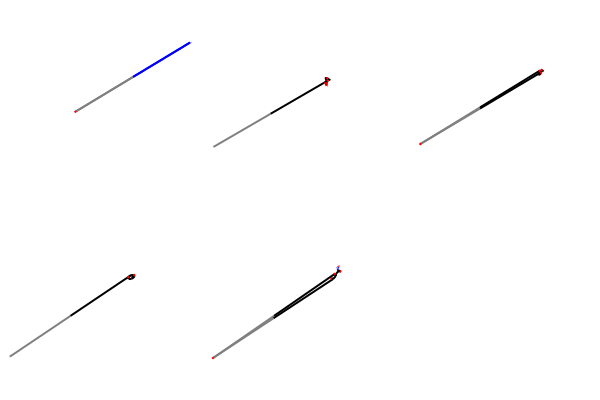

In [6]:
# you can get MOL object by option returnMols=True but these keep conformation so it's not suitable to draw
f_mols = BRICS.BRICSDecompose(mols[0], returnMols=True)
Draw.MolsToGridImage(f_mols, molsPerRow=3)

[1*]C(=O)C(C[8*])CC(=O)N[O-].[1*]C(=O)C([4*])C(C)CC.[16*]c1ccccc1.[4*]C(CC(C)C)C(=O)[O-].[5*]N[5*].[5*]N[5*]


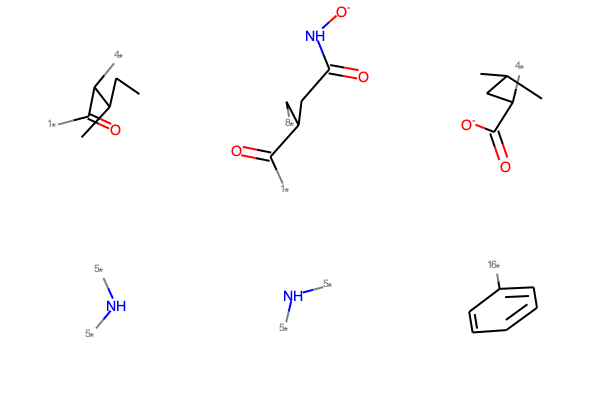

In [7]:
# mark parts by BreakBRICSBonds method
m = BRICS.BreakBRICSBonds(mols[0])
print(Chem.MolToSmiles(m))
fm = Chem.GetMolFrags(m, asMols=True)
Draw.MolsToGridImage(fm, molsPerRow=3)

In [8]:
# adapt BRICS to all molecules
cnt = Counter()
for mol in mols[:1000]:
    pieces = BRICS.BRICSDecompose(mol)
    for p in pieces:
        cnt[p] += 1
len(cnt)

1298

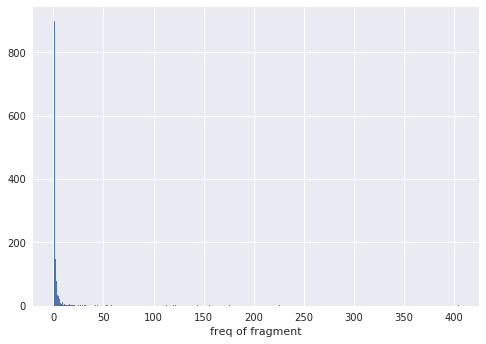

In [9]:
with plt.style.context('seaborn'):
    plt.hist(cnt.values(), bins=range(max(cnt.values())+1))
#     plt.hist(cnt.values())
    plt.xlabel('freq of fragment')

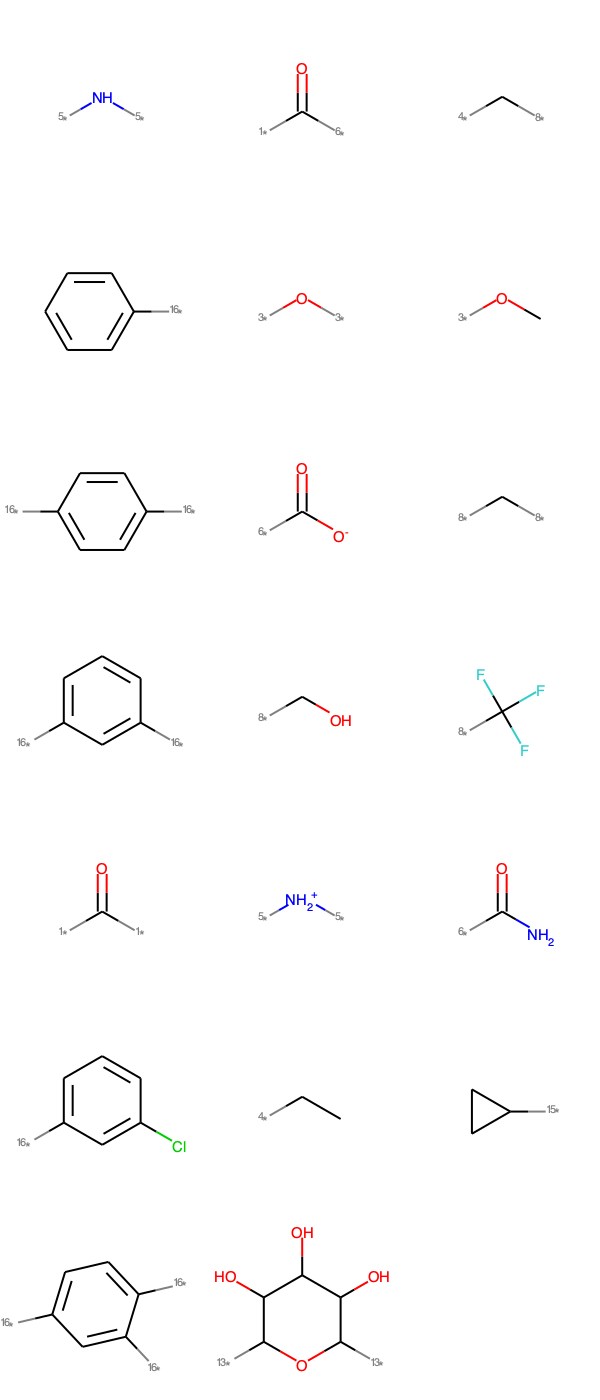

In [10]:
# 上記ヒストグラムの上位9個ぐらいをどうにかしてDrawしたいのでやり方を調べる
# type(cnt)
# return an ordered list of elements from highest 6
# print(cnt.most_common(6))

tmp = []

for l in cnt.most_common(20):
    tmp.append(Chem.MolFromSmiles(l[0]))

Draw.MolsToGridImage(tmp)

In [11]:
# build vertual library by BRICS
allfrags = set()
for mol in mols[:500]:
    frag = BRICS.BRICSDecompose(mol)
    allfrags.update(frag)
len(allfrags)

780

In [16]:
### convert from smiles to MOL object create generator
allcomponents = [Chem.MolFromSmiles(f) for f in allfrags]
builder = BRICS.BRICSBuild(allcomponents)
type(builder)

generator

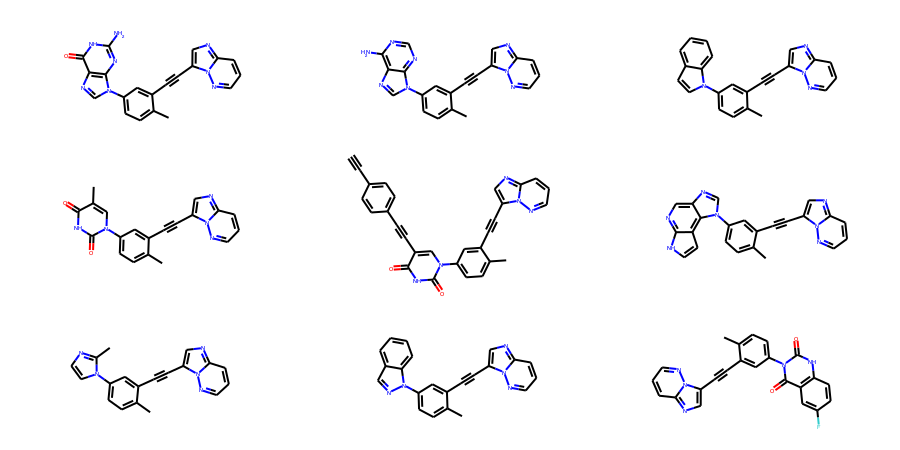

In [17]:
### shuffle molecules
generated_mols = []
for i in range(10):
    m = next(builder)
    m.UpdatePropertyCache(strict=True)
    generated_mols.append(m)

np.random.seed(1234)
np.random.shuffle(generated_mols)
Draw.MolsToGridImage(generated_mols[:9], molsPerRow=3, subImgSize=(300,150))

In [18]:
all_leaves = set()
for mol in mols:
    tree = Recap.RecapDecompose(mol)
    leaves = tree.GetLeaves().keys()
    all_leaves.update(leaves)
len(all_leaves)

4469

In [19]:
def recap_frag_smiles(mols):
    all_leaves=set()
    for mol in mols:
        tree = Recap.RecapDecompose(mol)
        leaves = tree.GetLeaves().keys()
        all_leaves.update(leaves)
    return all_leaves

def brics_frag_smiles(mols):
    all_frags = set()
    for mol in mols:
        frags = BRICS.BRICSDecompose(mol)
        all_frags.update(frags)
    return all_frags

%timeit recap_frag_smiles(mols)
%timeit brics_frag_smiles(mols)

14.6 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21 s ± 347 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
